# MISURAZIONE DIRETTA ANGOLO DI MINIMA DEVIAZIONE

misurazioni fatte in data 24 maggio (OK DA METTERE NELLA RELAZIONE)

1. ponendo il prisma sulla piattaforma e lampada ad Hg sono stati raccolti i valori degli angoli di minima deviazione $\delta_m$ per le righe dello spettro

#### CONSIDERAZIONI QUALITATIVE sulle linee osservate:
 - Rosso: poco visibile
 - Giallo: molto visibile
 - Verde: molto visibile
 - Acqua: abbastanza visibile (doppia)
 - Blu: molto visibile
 - Viola: raccolti i dati di due tonalità di viola ma poco visibili


$\sin{(\frac{\delta_m + \alpha}{2})} = n \cdot \sin\frac{\alpha}{2}$

$n(\lambda) = a + \frac{b}{\lambda^2}$

OBIETTIVO: stimare parametri _a,b_

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
from jax import grad
from jax import numpy as jnp

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from giopy import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'prisma.csv'
fr = pd.read_csv(FILE)
fr = fr.sort_values('RIFLESSA deg')

sono state raccolte 3 misure per ogni $\delta_m$:
- $\sigma_\alpha$ = 0 trascuriamo (da non scrivere nella relazione)
- $\sigma_{\delta_m}$ = da deviazione standard (con correzzione Bessel) 

In [2]:
FILE = dir_path + '/data/' + 'prismaHg.csv'
fr = pd.read_csv(FILE)

α,sigmaα = 60.18,0#  np.float64(60.18), np.float64(0.35) # calcolati in angolo_alpha
errore_lettura = 1/60 # minimo per non avere std = 0

# ROSSO deg ,ROSSO prim,GIALLO deg,GIALLO prim,VERDE deg,VERDE prim,ACQUA deg,ACQUA prim,BLU deg,BLU prim,VIOLA2 deg,VIOLA2 prim,VIOLA 1 deg,VIOLA 1 prim

rosso = np.array(fr['ROSSO deg'] + fr['ROSSO prim']/60)
verde = np.array(fr['VERDE deg'] + fr['VERDE prim']/60)
blu = np.array(fr['BLU deg'] + fr['BLU prim']/60)
viola1 = np.array(fr['VIOLA 1 deg'] + fr['VIOLA 1 prim']/60)
viola2 = np.array(fr['VIOLA2 deg'] + fr['VIOLA2 prim']/60)
acqua = np.array(fr['ACQUA deg'] +  fr['ACQUA prim']/60)
giallo = np.array(fr['GIALLO deg'] + fr['GIALLO prim']/60)

rossom, sigmarosso = np.mean(rosso), np.std(rosso)*3/2 # bessel correction
verdem, sigmaverde = np.mean(verde), np.std(verde)*3/2
blum, sigmablu = np.mean(blu), np.std(blu)*3/2
viola1m, sigmaviola1 = np.mean(viola1), np.std(viola1)*3/2
viola2m, sigmaviola2 = np.mean(viola2), np.std(viola2)*3/2
acquam, sigmaacqua = np.mean(acqua), np.std(acqua)*3/2
giallom, sigmagiallo = np.mean(giallo), np.std(giallo)*3/2

FILE = dir_path + '/data/' + 'LINEE_SPETTRO_Hg.csv'
fr = pd.read_csv(FILE)
fr.set_index('colore',inplace=True)
Hg = fr.sort_values('λ (nm)',ascending=False)

# ESCLUDO I VIOLA IN QUANTO DIFFICILMENTE VISIBLI

δm = 360 - np.array([rossom,giallom,verdem,acquam,blum])
# sommo in quadratura con valore trovato in errori 
sigmaδm = np.sqrt(np.array([sigmarosso,sigmagiallo,sigmaverde,sigmaacqua,sigmablu])**2 + errore_lettura**2) 

#print('λ (tabulati) (Hg) [nm]: ',λ_Hg)
# print('sigmaλ (Hg) [nm]: ',sigmaλ_Hg)
print('Angolo minima deviazione [deg]: ',np.round(δm,2))
print('sigmaδm [deg]: ',np.round(sigmaδm,2))
print('-------------- lunghezze d\'onda spettro Hg: ---------------')
print(Hg)

Angolo minima deviazione [deg]:  [48.06 48.33 48.78 49.39 50.47]
sigmaδm [deg]:  [0.12 0.02 0.24 0.12 0.06]
-------------- lunghezze d'onda spettro Hg: ---------------
         λ (nm)
colore         
ROSSO       615
GIALLO2     579
GIALLO1     578
VERDE       546
ACQUA2      492
ACQUA1      485
BLU         436
VIOLA2      405
VIOLA1      392


$n = \frac{\sin{(\frac{\delta_m + \alpha}{2})}}{\sin\frac{\alpha}{2}}$

In [3]:
def indice_rifrazione(δm,α): # α = 60.18, δm = angolo minima deviazione
    return jnp.sin((δm + α)/2 * jnp.pi/180) / jnp.sin(α*jnp.pi/180)

def sigma_indice_rifrazione(δm,sigmaδm,α,sigmaα):
    didδ = np.array([grad(indice_rifrazione,argnums=0)(i,α) for i in δm])
    dida = np.array([grad(indice_rifrazione,argnums=1)(i,α) for i in δm])
    return jnp.sqrt((didδ * sigmaδm)**2 + (dida * sigmaα)**2)

n = indice_rifrazione(δm,α)
sigman = sigma_indice_rifrazione(δm,sigmaδm,α,sigmaα)

print('n: ',np.round(n,5),' ± ',np.round(sigman,5))

n:  [0.93388 0.93551 0.93812 0.94167 0.94791]  ±  [0.0007  0.0001  0.00138 0.00069 0.00035]


----------------- VALORI FIT: -----------------
a: (9.193 ± 0.005)e-1 
b: (5.438 ± 0.155)e3 

dof: 3
chi2: 0.28
chi2 ridotto: 0.09
pvalue: 0.96
------------------------------------------------



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.2799                     │              Nfcn = 46               │
│ EDM = 6.07e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 919.3e-3  │  0.5e-3   │            │            │         │         │       │
│ 1 │ b    │  5.44e3   │  0.15e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────┐
│   │            a            b │
├───┼───────────────────────────┤
│ a │     2.47e-07 -75.65301e-3 │
│ b │ -75.65301e-3      2.4e+04 │
└───┴───────────────────────────┘

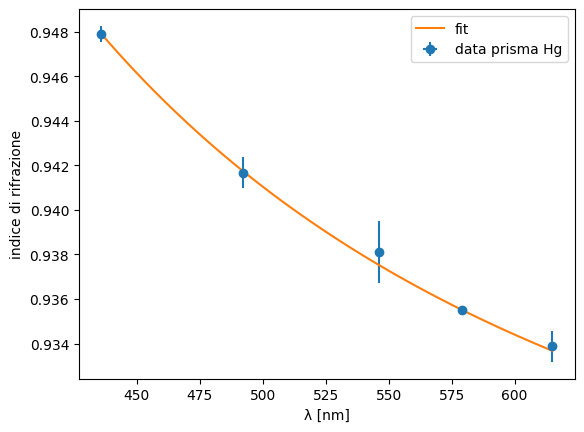

In [4]:
######################## stima parametri a , b ############################

def indice_rifrazione_lambda(λ,a,b):
    return a + b/(λ**2) # formula di Cauchy

λ_osservabili = np.array([Hg.loc['ROSSO'][0],Hg.loc['GIALLO2'][0],Hg.loc['VERDE'][0],Hg.loc['ACQUA2'][0],Hg.loc['BLU'][0]]) #,Hg.loc['VIOLA2'][0],Hg.loc['VIOLA1'][0]])
# print(λ_osservabili)
fit = Interpolazione(λ_osservabili, n, sigman, np.zeros_like(λ_osservabili), indice_rifrazione_lambda, [0.921, 5400], names=['a','b'])
print(fit)
display(fit.m)

plt.errorbar(fit.X,fit.Y,yerr=fit.sigmaY,xerr=fit.sigmaX,fmt='o',label='data prisma Hg')
plt.xlabel('λ [nm]')
plt.ylabel('indice di rifrazione')
plt.plot(*fit.draw(),label='fit')
plt.legend()
plt.show()

# GAS IGNOTO CON PRISMA:

$\lambda = \sqrt{\frac{b}{n - a}} $

È stato raccolto un singolo valore $\delta_m$ per ogni frangia:
- $\sigma_{\delta_m} = 13.44'$ (calcolati nel punto _errori.ipynb_)
- $\sigma_\alpha =$ trascurato

In [9]:
FILE = dir_path + '/data/' + 'prisma_gas_incognito.csv'

fr = pd.read_csv(FILE)
fr.set_index('colore',inplace=True)
fr = fr.sort_values('DEG')

δm = 360 - np.array(fr['DEG'] + fr['PRIM']/60)
errore_lettura = np.float64(0.224)
sigmaδm = np.ones_like(δm) * errore_lettura # proveniente da errori

n = indice_rifrazione(δm,α) # funzione definita sopra
sigman = sigma_indice_rifrazione(δm,sigmaδm,α,sigmaα) # funzione definita sopra

def lambda_from_indice_rifrazione(n,a = fit.values['a'],b = fit.values['b']):
    return jnp.sqrt(b/(n - a))

def sigma_indice_rifrazione_lambda(n,sigman,sigmaa,sigmab,a = fit.values['a'],b = fit.values['b'],sigmaab = fit.covariance[0][1]):
    dda = np.array([grad(lambda_from_indice_rifrazione, argnums=1)(i,a,b) for i in n])
    ddb = np.array([grad(lambda_from_indice_rifrazione, argnums=2)(i,a,b) for i in n])
    ddn = np.array([grad(lambda_from_indice_rifrazione, argnums=0)(i,a,b) for i in n])
    return jnp.sqrt((dda * sigmaa)**2 + (ddb * sigmab)**2 + (ddn * sigman)**2 + 2 * dda * ddb * sigmaab)

λ_ignoto = lambda_from_indice_rifrazione(n)
sigmaλ_ignoto = sigma_indice_rifrazione_lambda(n,sigman,fit.errors['a'],fit.errors['b'])

print('δm',δm)
print('n: ',n)
print('λ [nm]: ',final_val(λ_ignoto,sigmaλ_ignoto,0,udm='nm'))

δm [51.25       50.41666667 49.33333333 48.33333333 48.66666667]
n:  [0.95234381 0.94759697 0.94135121 0.93551119 0.9374658 ]
λ [nm]:  [406. 438. 497. 579. 547.] ± [ 8. 10. 15. 24. 20.] nm


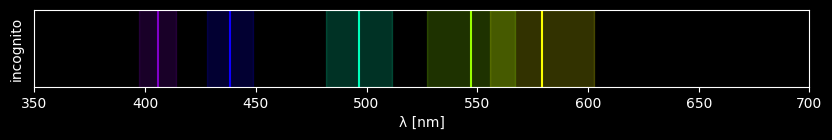

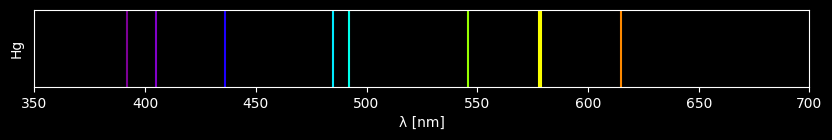

In [10]:
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/')
from spectra_reppresentation import draw_spectrum

draw_spectrum(λ_ignoto,sigmaλ_ignoto,ytitle='incognito')
draw_spectrum(Hg['λ (nm)'],ytitle='Hg')

In [7]:
# QUANTIFICAZIONE COMPATIBILITA':
from scipy.stats import chi2 as chi2f

λ_osservabili = np.sort(np.array([Hg.loc['GIALLO2'][0],Hg.loc['VERDE'][0],Hg.loc['ACQUA2'][0],Hg.loc['BLU'][0],Hg.loc['VIOLA2'][0]]))
λ_ignoto = np.sort(λ_ignoto)
chi2 = np.sum(((λ_osservabili - λ_ignoto)/sigmaλ_ignoto)**2)
df = len(λ_osservabili) - 1
pvalue = np.round(chi2f.sf(chi2,df),3)

print('λ_osservabili: ',λ_osservabili)
print('λ_ignoto: ',λ_ignoto)

print('chi2: ',np.round(chi2,3))
print('df: ',df)
print('rchi2: ',np.round(chi2/df,2))
print('pvalue: ',pvalue)


λ_osservabili:  [405 436 492 546 579]
λ_ignoto:  [405.64336659 438.34485482 496.54977802 547.07256501 579.10874354]
chi2:  0.155
df:  4
rchi2:  0.04
pvalue:  0.997


sopra lo spettro del gas ignoto sotto quello dell'Hg

I due spettri sono compatibili fra loro

__NOTA__: è probabile che le tonalità di viola osservate siano poco attendibili (viola1 e viola2). Effettivamente sono presenti righe in quella regione ma poco visibili, potrebbe esserci un bias nella scelta dei valori di $\lambda$

# INCOGNITO 2:

le incertezze sono analoghe al punto precedente

λ_ignoto:  [665. 579. 547. 486. 463.]  ±  [36. 24. 20. 14. 12.]


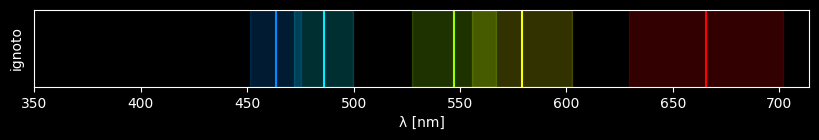

In [11]:
FILE = dir_path + '/data/' + 'incognito2.csv'

fr = pd.read_csv(FILE)
fr.set_index('strumento',inplace=True)
fr = fr.loc['PRISMA']

rosso = np.array(fr['ROSSOdeg'] + fr['ROSSOprim']/60)
giallo = np.array(fr['GIALLOdeg'] + fr['GIALLOprim']/60)
verde = np.array(fr['VERDEdeg'] + fr['VERDEprim']/60)
azzurro = np.array(fr['AZZURROdeg'] + fr['AZZURROprim']/60)
blu = np.array(fr['BLUdeg'] + fr['BLUprim']/60)

δm = np.array([rosso,giallo,verde,azzurro,blu])
δm = 360 - δm
σδm = np.ones_like(δm) * errore_lettura # incertezza proveniente da errori

n = indice_rifrazione(δm,α)
sigman = sigma_indice_rifrazione(δm,σδm,α,sigmaα)

λ_ignoto = lambda_from_indice_rifrazione(n)
σλ_ignoto = sigma_indice_rifrazione_lambda(n,sigman,fit.errors['a'],fit.errors['b'])

print('λ_ignoto: ',np.round(λ_ignoto),' ± ',np.round(σλ_ignoto))

draw_spectrum(λ_ignoto,σλ_ignoto,ytitle='ignoto')